<a href="https://colab.research.google.com/github/MitaliThorat1316/Twitter-Sentiment-Analysis/blob/main/Bert_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing and Importing dependencies**

In [1]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

#!pip install transformers


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

**Changing device to GPU**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


**Load dataset**

In [12]:
df = pd.read_csv(r'/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',
                    encoding='ISO-8859-1',
                    names = ['sentiment','ids','date', 'flag', 'user', 'tweet'])

**Dataset Analysis**

In [13]:
df.head()

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
data=df[['tweet','sentiment']]

In [16]:
data.loc[:, 'sentiment'] = data['sentiment'].replace(4, 1)

In [18]:
data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

In [19]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [20]:
dataset = pd.concat([data_pos, data_neg])

In [21]:
dataset.head()

,tweet,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [22]:
dataset.sentiment.unique()

array([1, 0])

In [23]:
X=dataset.tweet
y=dataset.sentiment

**Splitting the data into training and testing**

In [24]:
# Separating the 80% data for training data and 20% for testing data
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y, random_state =42)

Training Set Class Distribution:
Class 0: 16000 samples
Class 1: 16000 samples

Testing Set Class Distribution:
Class 0: 4000 samples
Class 1: 4000 samples


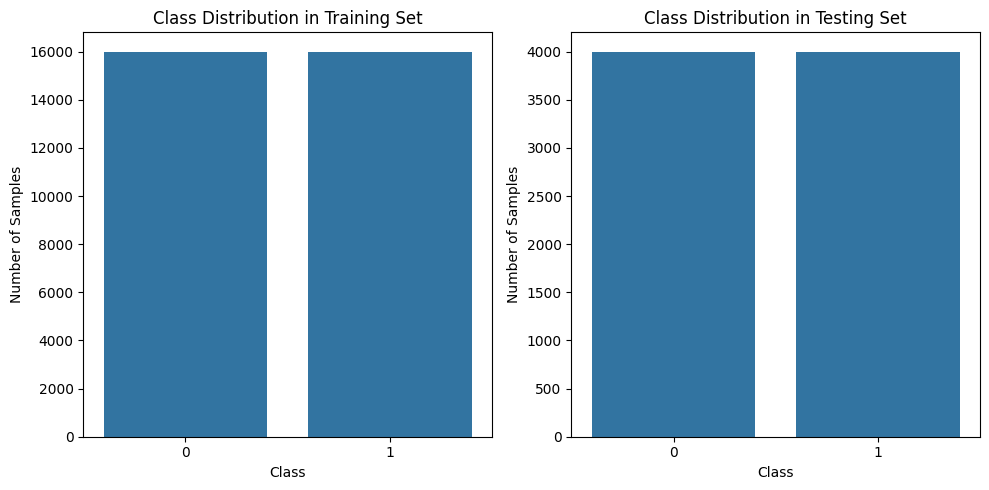

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class in y_train and y_test
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

# Display the counts
print("Training Set Class Distribution:")
for label, count in zip(unique_train, counts_train):
    print(f"Class {label}: {count} samples")

print("\nTesting Set Class Distribution:")
for label, count in zip(unique_test, counts_test):
    print(f"Class {label}: {count} samples")

# Plotting the distribution for training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=unique_train, y=counts_train)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# Plotting the distribution for testing set
plt.subplot(1, 2, 2)
sns.barplot(x=unique_test, y=counts_test)
plt.title('Class Distribution in Testing Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()


**Tokenization**

In [27]:
# Load the BERT tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:
train_tokens = tokenizer.batch_encode_plus(x_train.tolist(),
                                           max_length = 375,
                                           padding=True,
                                           truncation=True,
                                           return_tensors = 'pt')

val_tokens = tokenizer.batch_encode_plus(x_test.tolist(),
                                         max_length = 375,
                                         padding=True,
                                         truncation=True,
                                         return_tensors = 'pt')

In [29]:
train_tokens

{'input_ids': tensor([[  101,  7632,  9468,  ...,     0,     0,     0],
        [  101,  1030,  9092,  ...,     0,     0,     0],
        [  101,  4365, 22794,  ...,     0,     0,     0],
        ...,
        [  101,  2145,  4586,  ...,     0,     0,     0],
        [  101,  4930,  2011,  ...,     0,     0,     0],
        [  101,  8299,  1024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

**Encoding**

In [30]:
#train set
train_ids = train_tokens['input_ids']
train_masks = train_tokens['attention_mask']
train_label = torch.tensor(y_train.tolist())

#test set
val_ids = val_tokens['input_ids']
val_masks = val_tokens['attention_mask']
val_label = torch.tensor(y_test.tolist())

In [31]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(train_ids,
                           train_masks,
                           train_label)

val_data = TensorDataset(val_ids,
                         val_masks,
                         val_label)

**Set Up BERT Pretrained Model**

In [32]:
from transformers import BertForSequenceClassification

#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

**Create Data Loaders**

In [39]:
train_loader = DataLoader(train_data,
                          batch_size = 16,
                          shuffle = True)

val_loader = DataLoader(val_data,
                        batch_size = 16,
                        shuffle = True)

**Set Up Optimizer and Scheduler**

In [40]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

#Load optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8)
#load scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(train_loader)*epochs)



**Define Performance Metrics**

In [34]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [35]:
# Overall accuracy function
def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [36]:
def evaluate(val_loader):

    #evaluation mode disables the dropout layer
    model.eval()

    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(val_loader):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():
            outputs = model(**inputs)

        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss
    loss_val_avg = loss_val_total/len(val_loader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

**Train Model**

In [37]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [41]:
def inspect_predictions(val_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for faster inference
        for batch in val_loader:
            # Move all batch elements to the device (e.g., GPU)
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            # Ensure the model is on the same device
            model.to(device)

            # Get model outputs
            outputs = model(**inputs)
            logits = outputs.logits  # Updated to access logits correctly

            # Get the predictions by selecting the class with the highest score
            predictions = torch.argmax(logits, dim=1)

            # Print the first 5 predictions and true labels, after moving them to CPU
            print('Predictions:', predictions[:5].cpu().numpy())
            print('True Labels:', inputs['labels'][:5].cpu().numpy())
            break  # Exit after the first batch for quick inspection

# Run the inspection function
inspect_predictions(val_loader)


Predictions: [0 0 0 0 0]
True Labels: [0 0 1 0 0]


In [42]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Initialize lists to store loss values
train_losses = []
val_losses = []

for epoch in tqdm(range(1, epochs+1)):

    #set model in train mode
    model.train()

    #tracking variable
    loss_train_total = 0

    #set up progress bar
    progress_bar = tqdm(train_loader,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        #set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        # Move model to GPU if not already there
        model.to(device)

        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()

        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write('\nEpoch {epoch}')

    #print training result
    loss_train_avg = loss_train_total/len(train_loader)
    train_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    #evaluate
    val_loss, predictions, true_vals = evaluate(val_loader)
    val_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')

    #f1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'F1 Score (weighted): {val_f1}')

    #accuracy
    val_acc = accuracy_func(predictions, true_vals)
    tqdm.write(f'Accuracy: {val_acc}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4231977513357997


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.36873764790594576
F1 Score (weighted): 0.8336541848104507
Accuracy: 0.83375


Epoch 2:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3099971374962479


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.39847335644811394
F1 Score (weighted): 0.8326285219619749
Accuracy: 0.832875


Epoch 3:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.22408854413428345


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.46561025884747503
F1 Score (weighted): 0.8329939877835603
Accuracy: 0.833


Epoch 4:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1641906667117728


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.6458460021018982
F1 Score (weighted): 0.8342290196102945
Accuracy: 0.83425


Epoch 5:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.12164484420052031


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.7875348384540993
F1 Score (weighted): 0.8291220924056035
Accuracy: 0.829125


Epoch 6:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.08796938433343894


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.8976947796680034
F1 Score (weighted): 0.8288930581613508
Accuracy: 0.829


Epoch 7:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.0696777062334877


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.9813198386925506
F1 Score (weighted): 0.8281245461413798
Accuracy: 0.828125


Epoch 8:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.04814351659495878


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 1.0786760103927227
F1 Score (weighted): 0.8311186643111407
Accuracy: 0.831125


Epoch 9:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.04266082385196933


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 1.1219074384329724
F1 Score (weighted): 0.8273742204867144
Accuracy: 0.827375


Epoch 10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.03336526083800709


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 1.1757679053494356
F1 Score (weighted): 0.8277498277498277
Accuracy: 0.82775


**Evaluation**

In [43]:
# Get predictions for the validation set
_, predictions, true_vals = evaluate(val_loader)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(true_vals, predicted_labels)
print(report)


  0%|          | 0/500 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4000
           1       0.83      0.83      0.83      4000

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



  0%|          | 0/500 [00:00<?, ?it/s]

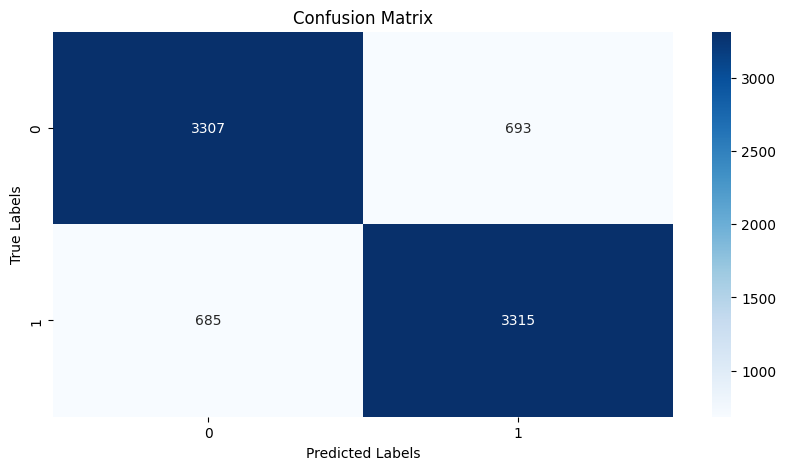

In [44]:
val_loss, predictions, true_vals = evaluate(val_loader)  # Get predictions
preds_flat = np.argmax(predictions, axis=1).flatten()  # Flatten predictions

# Generate confusion matrix
cm = confusion_matrix(true_vals, preds_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
